In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import Sequential
from keras import layers
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import adam_v2
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import random
from tqdm.notebook import tqdm
import collections
from keras.models import load_model

In [2]:
# train_data = np.array(pd.read_pickle('F:/df/NoDef/X_train_NoDef.pkl')) # shape (76000, 5000), 95 website, 800 repeat
# train_index = np.array(pd.read_pickle('F:/df/NoDef/y_train_NoDef.pkl')) # shape (76000,), 0-94 range, random

test_data = np.array(pd.read_pickle('D:/F/df/NoDef/X_test_NoDef.pkl')) # shape (9500, 5000), 95 website, 100 repeat
test_index = np.array(pd.read_pickle('D:/F/df/NoDef/y_test_NoDef.pkl')) # shape (9500,), 0-94 range, sequence

In [3]:
model = load_model('data/model_tor_walkietalkie_aug.h5')

In [4]:
model.evaluate(test_data.astype('float32'), to_categorical(test_index))

297/297 [==============================] - 20s 65ms/step - loss: 0.2503 - accuracy: 0.9477


[0.2503190040588379, 0.9476842284202576]

In [5]:
def get_data_length(data_vector):
    data_length = 5000
    for i in range(5000):
        if data_vector[i] == 0:
            data_length = i
            break
    return data_length

def walkie_talkie(data_vector, buffer_len):
    buffer = list()
    data_output = np.zeros(5000, dtype=int)
    index = 0
    for i in data_vector:
        buffer.append(i)
        if len(buffer) >= buffer_len:
            stat = collections.Counter(buffer)
            for j in range(stat[1]):
                data_output[index] = 1
                index += 1
            for j in range(stat[-1]):
                data_output[index] = -1
                index += 1
            buffer.clear()
            if stat[0] > 0:
                break
    return data_output

def add_noise(data_vector, data_length, count):
    for i in range(count):
        location = random.randint(0, data_length - 1)
        packet = data_vector[location]
        data_vector = np.insert(data_vector, location, packet)
        if data_length < 5000:
            data_length += 1
    
    return data_vector[0 : 5000]

In [6]:
res = np.zeros(21)
rate_list = np.linspace(0, 1, num=21, endpoint=True)
for j in range(21):
    rate = rate_list[j]
    test_data_noise = test_data.copy()
    for i in range(9500):
        length = get_data_length(test_data_noise[i])
        test_data_noise[i] = walkie_talkie(test_data_noise[i], 20)
        test_data_noise[i] = add_noise(test_data_noise[i], length, int(length * rate))
    res[j] = model.evaluate(test_data_noise.astype('float32'), to_categorical(test_index))[1]

297/297 [==============================] - 17s 56ms/step - loss: 0.6345 - accuracy: 0.8469


(0.0, 1.0)

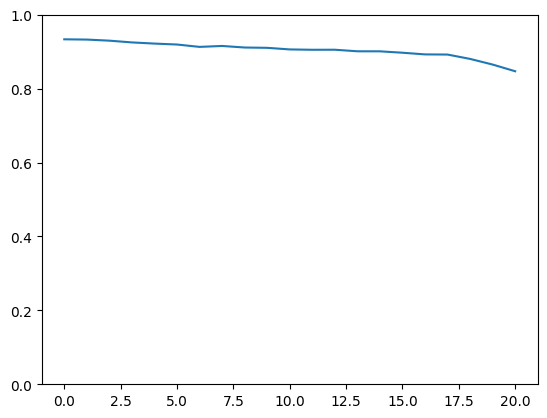

In [7]:
plt.plot(res)
plt.ylim((0, 1))

In [8]:
np.save('data/res_tor_walkietalkie_aug.npy', res)